## MFPT tinker

Slack message from JHP:
>Good point. I was wondering how good that worked. I never really tried that with a real system. I guess you should write down exactly the concept on how to determine a metastable state with ​_size_​ tau. This is not clear to me but I would be interested in how you would write that down. An example. I naively think a local MFPT state of size tau is a set of states that:
1. have a center
2. there is no ​_drift_​ (needs to be defined) in the sense that a neighboring state (what is a neighbor) is not energetically lower.
3. all states states with in the tau radius of the center will have the tendency that the center is ​_lower_​ (define)
So that this resembles the idea of a local minima when we could actually plot a dynamic energy landscape. I think `A lower than B` means that `mfpt(A,B) > mfpt(B,A)` (needs to be thought about)

>if you can do that. We have an extremely powerful tool to decompose an MSM into stable states and directly define interfaces... I am under a tight schedule now. Would it possible for you to try that until say beginning of August? Around the time John returns?
When we have solved that, we can couple OPS with an MSM simulation and start playing around and see if it actually improves. The rest is just doing it with a real system and publish it :slightly_smiling_face:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# imports
from msmbuilder.example_datasets import MetEnkephalin
trajs = MetEnkephalin().get().trajectories
import pyemma
feat = pyemma.coordinates.featurizer(trajs[0].top)
pairs = []
for i in range(trajs[0].n_atoms)[::2]:
    for j in range(i)[::2]:
        pairs.append((i,j))
feat.add_distances(pairs)
feat.add_backbone_torsions(cossin=True)
print(len(feat.describe()))

X = [feat.transform(traj) for traj in trajs]
tica = pyemma.coordinates.tica(X)
X_tica = tica.get_output()

from pyemma.coordinates import cluster_mini_batch_kmeans
kmeans = cluster_mini_batch_kmeans(X_tica,k=1000,max_iter=100)
dtrajs = [dtraj.flatten() for dtraj in kmeans.get_output()]

719
29-07-16 09:59:40 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2] INFO     Algorithm did not reach convergence criterion of 1e-05 in 100 iterations. Consider increasing max_iter.


In [3]:
lags = range(1,10) + range(10, 100)[::10] + range(100,1000)[::100]
its = pyemma.msm.its(dtrajs, lags = lags, nits = 10)

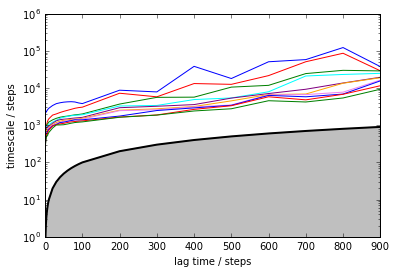

In [4]:
pyemma.plots.plot_implied_timescales(its)

In [5]:
msm = pyemma.msm.estimate_markov_model(dtrajs,10)
msm.active_count_fraction

0.9965170743424476

In [6]:
# get an MFPT matrix (or a few)
n = msm.nstates
import numpy as np

def _slow_mfpt_matrix(msm):
    '''
    Compute the mean first-passage time matrix from a pyemma.MSM object,
    by making nstates^2 calls to `self.mfpt`.
    
    For testing purposes.
    
        
    Returns
    -------
    mfpt : (nstates,nstates), numpy.ndarray
        mfpt[i,j] = self.mfpt(i,j)
    '''
    n = msm.nstates
    mfpt = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            mfpt[i,j] = msm.mfpt(i,j)
    return mfpt

def mfpt_matrix(msm):
    """
    Compute the mean first-passage time matrix from a pyemma.MSM object,
    using the generalized inverse.
    
    
    Parameters
    ----------
    msm : :obj:`PyEmma.MSM`
        the MSM object to be analyzed
        
    
    """
    tm = msm.P
    size = msm.nstates

    eq = msm.stationary_distribution

    im = np.identity(size)
    wm = np.tile(eq, (size, 1))

    # A = 1 - P

    ahash =  np.linalg.inv(im - (tm - wm)) - wm
    adg = np.diag(np.diagonal(ahash))

    dm = np.diag(1.0 / eq)
    jm = np.ones((size,size))
    mm = (np.dot(im - ahash + np.dot(jm, adg), dm))

    return (mm - np.diag(np.diag(mm))) * msm.lagtime

mfpt = mfpt_matrix(msm)

In [7]:
msm.mfpt(10,15),mfpt[10,15]

(33015.250000930013, 33015.250000929758)

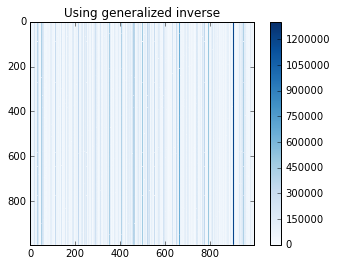

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(mfpt,interpolation='none',cmap='Blues')
plt.colorbar()
plt.title('Using generalized inverse')

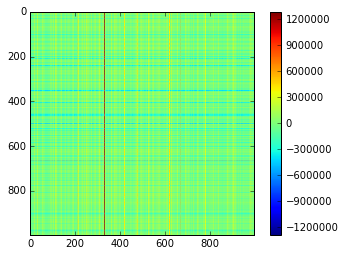

In [9]:
plt.imshow(mfpt - mfpt.T)
plt.colorbar()

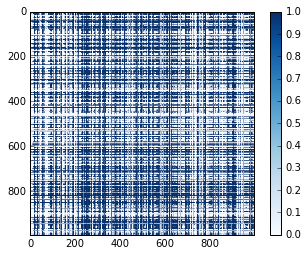

In [10]:
plt.imshow((mfpt - mfpt.T > 0), cmap='Blues')
plt.colorbar()

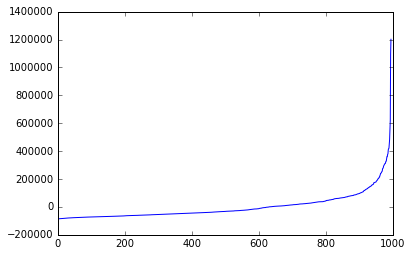

In [11]:
plt.plot(sorted((mfpt - mfpt.T).mean(0)))

In [12]:
# this matrix encodes which pairs of states are most "non-level"

# big positive numbers --> takes much longer to go i->j than j->i
# big negative numbers --> takes much longer to go j->i than i->j

# centers: 

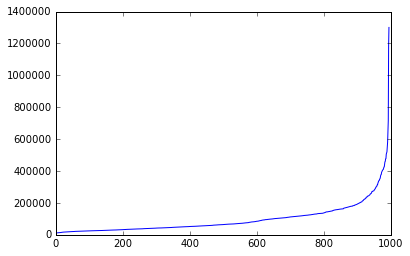

In [13]:
plt.plot(sorted(mfpt[0]))

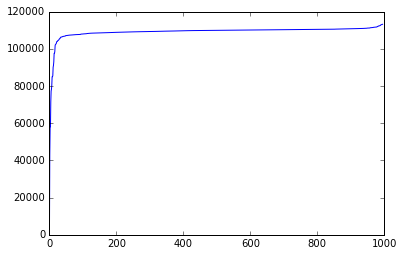

In [14]:
plt.plot(sorted(mfpt[:,0]))

In [15]:
# define checks:
# center of a state
# drift

In [20]:
import itertools

In [16]:
class Decomposition():
    def __init__(self, MFPT_matrix, partition, centers, tau):
        self.mfpt = MFPT_matrix
        self.partition = partition
        self.centers = centers
        self.tau = tau
    
    def check_partition(self):
        ''' Check that the partition is a proper partition'''
        flattened = list(itertools.chain(*self.partition))
        complete = len(set(flattened)) == len(MFPT_matrix)
        nonredundant = len(flattened) == len(MFPT_matrix)
        return complete and nonredundant
    
    def check_centers(self):
        ''' Each state has a unique center'''
        same_number = (len(self.centers) == len(self.partition))
        no_duplicates = (len(self.centers) == len(set(self.centers)))
        return same_number and no_duplicates
    
    def get_states_within_tau(self, i, tau = None):
        if not tau:
            tau = self.tau
        return np.where(self.mfpt[i] < tau)[0]
    
    def is_lower(self, i, j):
        '''
        Is it faster to get from j->i than from i->j ?
        
        To-do: say whether this is true using a statistical test?
        '''
        return self.mfpt[j, i] < self.mfpt[i,j]
    
    
    def get_neighbors(self, i):
        ''' 
        How to define? MFPT
        '''
        pass

In [17]:
def diffusion_distance(msm, i, j):
    '''
    D^2(i,j) = \sum_k (P[i,k] - P[j,k])^2 / \pi_k
    
    http://cims.nyu.edu/~holmes/teaching/asa15/Lecture3.pdf
    
    '''
    
    return np.sum((msm.P[i] - msm.P[j])**2 / msm.stationary_distribution)

In [392]:
n = msm.nstates
diffusion_distance_matrix = np.zeros((n,n))
for i in range(n):
    for j in range(i):
        diffusion_distance_matrix[i,j] = diffusion_distance(msm, i, j)
diffusion_distance_matrix = diffusion_distance_matrix + diffusion_distance_matrix.T

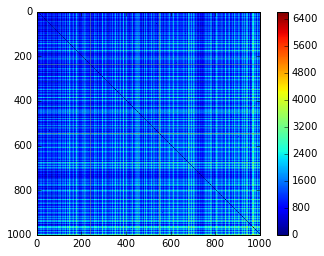

In [394]:
plt.imshow(diffusion_distance_matrix)
plt.colorbar()

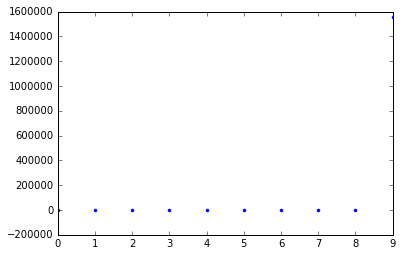

In [399]:
vals, vecs = np.linalg.eigh(diffusion_distance_matrix)
plt.plot(sorted(vals)[-10:],'.')

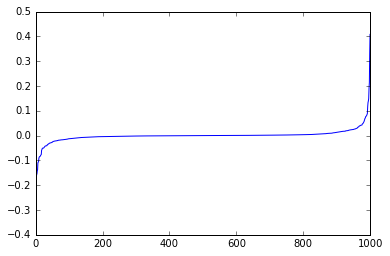

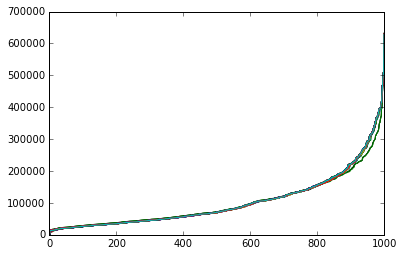

In [299]:
for i in range(len(mfpt))[::5]:
    plt.plot(sorted(mfpt[i]))

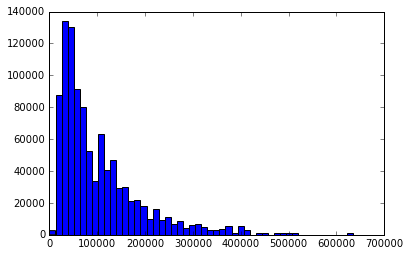

In [300]:
plt.hist(mfpt.flatten(),bins=50);

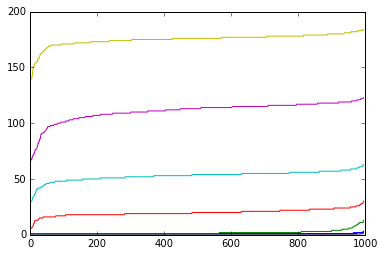

In [18]:
for tau in [10, 100, 500, 1000, 2000, 3000, 4000, 5000, 10000, 15000, 20000, 25000, 30000]:
    states_within_tau = [np.where(mfpt[i] < tau)[0] for i in range(len(mfpt))]
    plt.plot(sorted([len(s) for s in states_within_tau]))

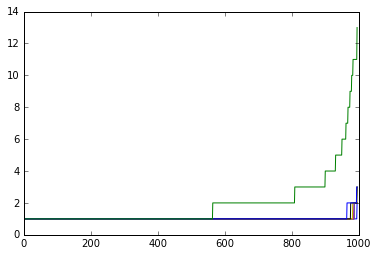

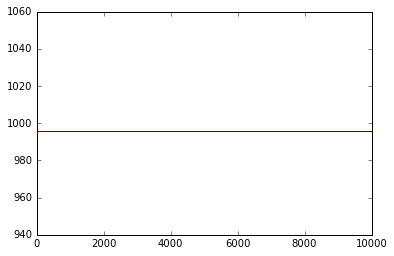

In [19]:
unions = []
taus = [10, 100, 500, 1000, 2000, 3000, 4000, 5000, 10000]
for tau in taus:
    states_within_tau = [np.where(mfpt[i] < tau)[0] for i in range(len(mfpt))]
    plt.plot(sorted([len(s) for s in states_within_tau]))
    unions.append(len(set(np.hstack(states_within_tau))))
plt.figure()
plt.plot(taus, unions)

In [20]:
# okay, so this is very sensitive: as I vary tau I 

In [21]:
tau = 10000
states_within_tau = [np.where(mfpt[:,i] < tau)[0] for i in range(len(mfpt))]

In [22]:
states_within_tau[0]

array([0])

In [23]:
max([len(s) for s in states_within_tau])

278

In [24]:
sorted([len(s) for s in states_within_tau])[::-1][:5]

[278, 74, 72, 69, 46]

In [25]:
def local_mfpt_minima(mfpt_matrix,tau):
    ''' Definition suggested by JHP '''
    
    
    n = len(mfpt_matrix)
    
    close_neighbors = []
    fast_returning_close_neighbors = []
    
    # for each microstate
    for i in range(n):
        neighbor_list = []
        fr_neighbor_list = [] # fast-returning neighborlist
        
        for j in range(n):
            
            # if i can reach j in less than time tau
            if mfpt_matrix[i,j]<tau and i!=j: 
                
                # consider it a neighbor
                neighbor_list.append(j) 
                
                # if it can return from j to i faster than it takes to get from i to j
                # consider it "fast-returning"
                if mfpt_matrix[i,j]>mfpt_matrix[j,i]:
                    fr_neighbor_list.append(j)
            
        close_neighbors.append(neighbor_list)
        fast_returning_close_neighbors.append(fr_neighbor_list)
        
    # core states {i | all of i's neighbors are fast-returning close_neighbors }
    core_states = [i for i in range(n) if \
                   set(close_neighbors[i]).issubset(set(fast_returning_close_neighbors[i])) \
                   and len(close_neighbors[i])>0]
    
    return close_neighbors,fast_returning_close_neighbors,core_states

close_neighbors,fast_returning_close_neighbors,core_states = local_mfpt_minima(mfpt.T, 10000)

100%|██████████| 36/36 [00:16<00:00,  2.19it/s]


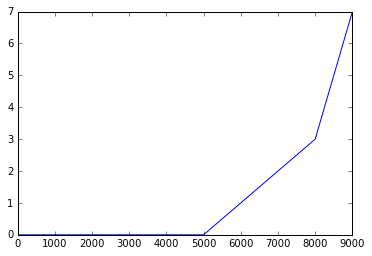

In [27]:
from tqdm import tqdm
n_core = []
taus = range(1,10) + range(10,100)[::10] + range(100,1000)[::100] + range(1000,10000)[::1000]
for tau in tqdm(taus):
    close_neighbors,fast_returning_close_neighbors,core_states = local_mfpt_minima(mfpt, tau)
    n_core.append(len(core_states))
plt.plot(taus, n_core)

100%|██████████| 90/90 [00:39<00:00,  2.22it/s]


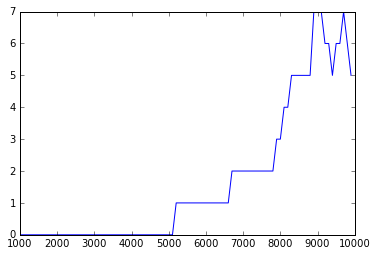

In [28]:
n_core = []
taus = range(1000,10000)[::100]
for tau in tqdm(taus):
    close_neighbors,fast_returning_close_neighbors,core_states = local_mfpt_minima(mfpt, tau)
    n_core.append(len(core_states))
plt.plot(taus, n_core)

100%|██████████| 100/100 [00:45<00:00,  2.14it/s]


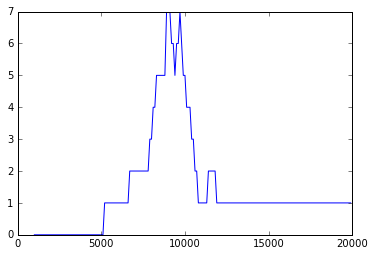

In [29]:
new_taus = range(10000, 20000)[::100]
for tau in tqdm(new_taus):
    close_neighbors,fast_returning_close_neighbors,core_states = local_mfpt_minima(mfpt, tau)
    n_core.append(len(core_states))
plt.plot(taus+new_taus, n_core)

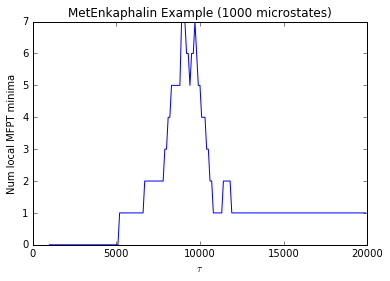

In [31]:
plt.plot(taus+new_taus, n_core)
plt.xlabel(r'$\tau$')
plt.ylabel('Num local MFPT minima')
plt.title('MetEnkaphalin Example (1000 microstates)')

In [135]:
close_neighbors,fast_returning_close_neighbors,core_states = local_mfpt_minima(mfpt, 1e7)
len(core_states)

1

In [62]:
len(set(np.hstack(states_within_tau)))

997

In [63]:
# set cover: what's the minimal set of centers such that the centrality condition holds?
# NP-complete, will need to pick an approximation algorithm...

In [64]:
# ways to map this into a vertex cover problem:
# http://networkx.github.io/documentation/networkx-1.7/reference/generated/networkx.algorithms.approximation.vertex_cover.min_weighted_vertex_cover.html#networkx.algorithms.approximation.vertex_cover.min_weighted_vertex_cover

# this would be nice, since we have an efficient 2-OPT approximation

# - unweighted digraph, where ((i,j) \in E) iff (MFPT[i,j] < tau).
#   I.e. what's the minimum collection of microstates required to be within tau-reach of 
#   all other microstates?


# - edge-weighted digraph, where w(i,j) = 1 / MFPT[i,j], and ((i,j) \in E) iff (MFPT[i,j] < tau).
#   I.e. what's the minimum collection of microstates to be within tau-reach of all other microstates, 
#   prioritized to reach 

# - vertex-weighted digraph, where the weight of each vertex is the stationary probability of the corresponding state


In [65]:
# can I other

In [32]:
# greedy algorithm: at every iteration, add the set containing the largest number of uncovered elements
# basically the best PTAS available for this problem, and easy to implement
# plus, these are in descending order of

# question: can we weight these somehow? because I want to include the highest

def greedy_set_cover(collection_of_sets, weights = None):
    
    # first, make sure these are sets -- may have been lists!
    sets = [set(s) for s in collection_of_sets]
    
    # get all the unique elements of these sets
    elements = set().union(*collection_of_sets)
    
    # keep track of which elements are currently in the cover
    in_cover = set()
    
    # the sets we've included, in order
    cover = []
    
    # the change in value of the cover at each iteration (for debugging)
    change_in_value = []
    
    while len(in_cover) < len(elements):
        # see how many new elements we could add to the cover, by
        # including each possible set
        which_ones_are_new = [s.difference(in_cover) for s in sets]
        if weights == None:
            benefit = [len(new) for new in which_ones_are_new]
        else:
            benefit = [sum([weights[i] for i in new]) for new in which_ones_are_new]
        
        # pick the set that would increase the (weighted) size of the cover the most
        i = np.argmax(benefit)
        
        cover.append(i)
        in_cover = in_cover.union(sets[i])
        change_in_value.append(benefit[i])
    
    return cover, change_in_value

In [72]:
tau = 10000
states_within_tau = [np.where(mfpt[:,i] < tau)[0] for i in range(len(mfpt))]

In [73]:
cover, change_in_value = greedy_set_cover(states_within_tau)

In [74]:
len(cover), cover[0],

(586, 429)

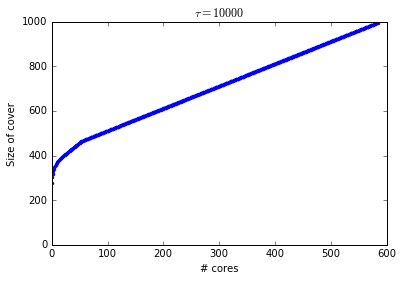

In [75]:
plt.plot(np.cumsum(change_in_value),'.')
plt.ylim(0,1000)
plt.ylabel('Size of cover')
plt.xlabel('# cores')
plt.title(r'$\tau={0}$'.format(tau))

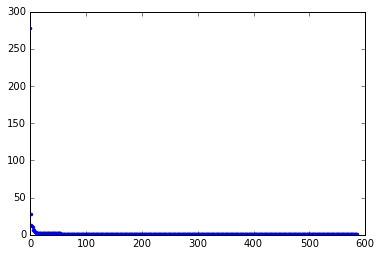

In [36]:
plt.plot(change_in_value,'.')

In [71]:
cover, change_in_value = greedy_set_cover(states_within_tau, weights = msm.stationary_distribution)

/Users/joshuafass/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


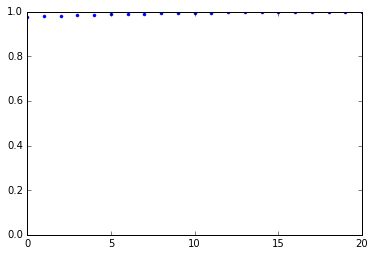

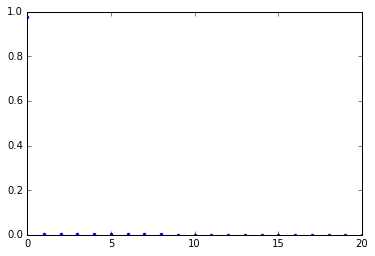

In [72]:
plt.plot(np.cumsum(change_in_value),'.')
plt.ylim(0,1)
plt.figure()
plt.plot(change_in_value,'.')

In [75]:
cover[0]

898

In [76]:
sum(mfpt[i]<tau)

2

In [77]:
s = set(range(5))
i = set(range(3))
s.difference(i)

{3, 4}

In [78]:
i.difference(s)

set()

In [79]:
i.add(5)

In [80]:
i

{0, 1, 2, 5}

In [81]:
i.add([6,7,8])

TypeError: unhashable type: 'list'

In [57]:
i.union([6,7,8])

{0, 1, 2, 5, 6, 7, 8}

In [ ]:
# assign to centers
# - given a collection of centers, assign a microstate to one of the centers

# how to do this:
# * argmin_i MFPT[center_i, microstate]
# * committors? argmin_i 

In [83]:
def assign_microstates_by_MFPT(MFPT, centers):
    '''
    
    Which center is closest?
    
    '''
    
    
    assignments = np.zeros(len(MFPT), dtype = int)
    
    for microstate in range(len(MFPT)):
        assignments[microstate] = np.argmin([MFPT[microstate, c] for c in centers])
    
    return assignments

In [84]:
assignments = assign_microstates_by_MFPT(mfpt, cover[:50])

In [85]:
len(set(assignments))

21

In [86]:
np.trace(msm.P), np.trace(msm.P) / len(msm.P)

(654.74939975172219, 0.65671955842700325)

In [90]:
msm._full2active

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [98]:
def coarse_grain(dtrajs, assignments):
    return [np.array([assignments[msm._full2active[d]] for d in dtraj], dtype = int) for dtraj in dtrajs]

dtrajs_cg = coarse_grain(dtrajs, assignments)

In [99]:
msm_cg = pyemma.msm.estimate_markov_model(dtrajs_cg, lag = 10)
np.trace(msm_cg.P), np.trace(msm_cg.P) / len(msm_cg.P)

(16.3964839889167, 0.7807849518531762)

In [270]:
import networkx as nx

In [278]:
G = nx.DiGraph(mfpt * (mfpt < tau))

In [283]:
len(G.edges())

3693

In [285]:
from networkx.algorithms.approximation import min_weighted_vertex_cover

In [286]:
min_weighted_vertex_cover(G)

NetworkXNotImplemented: not implemented for directed type

In [351]:
G = nx.Graph((mfpt < tau*2))

In [356]:
np.sum(mfpt < (tau*2))

421177

In [352]:
cover = min_weighted_vertex_cover(G)

In [353]:
len(cover)

999

In [340]:
vals, vecs = np.linalg.eig(mfpt-mfpt.T)

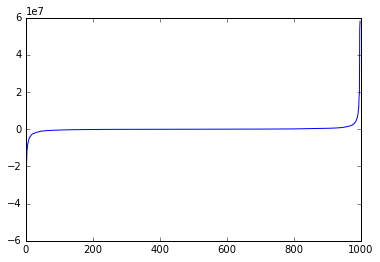

In [339]:
plt.plot(sorted(vals[1:]))

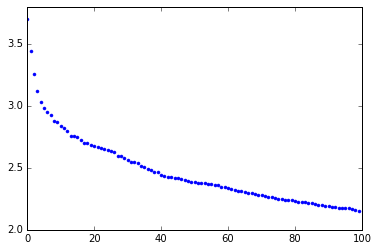

In [346]:
plt.plot(np.log10(msm.timescales())[:100],'.')

In [ ]:
# what if I just want to pick the set of 